# Model Selection: Machine Learning vs Statistics



This is related to https://stats.stackexchange.com/questions/241199/bonferroni-correction-machine-learning

$$y = a \alpha + \beta_1 x + \beta_2 x^2 \cdots + \beta_n x^n $$

What is the best model? How many exponents and which ones should we use?

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)

n_samples = 100
degrees = [1, 2, 3, 20]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.25


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)

# Data and the Question

We have some data and we want to fit a model. What's the best kind of model to fit? This is a question of model selection. Note this is different from asking, "given my model, what are the best parameters?" Here we are concerned with _hyperparameters_.

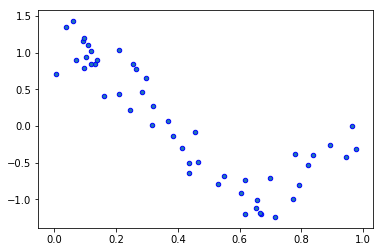

In [4]:
plt.scatter(X_test, y_test, edgecolor='b', s=20, label="Samples");

# The Classical Way

The process might go like this: let's fit some models and look at the p-values. 

In [5]:
import statsmodels.api as sm

In [6]:
X_try = X_train.reshape(50, 1)[:,[0,0,0,0]] ** degrees

In [7]:
# Note the difference in argument order
model = sm.OLS(y_train, X_try).fit()
predictions = model.predict(X_try) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     45.45
Date:                Thu, 12 Sep 2019   Prob (F-statistic):           2.02e-15
Time:                        20:27:43   Log-Likelihood:                -20.832
No. Observations:                  50   AIC:                             49.66
Df Residuals:                      46   BIC:                             57.31
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             9.0903      1.197      7.593      0.000       6.680      11.500
x2           -33.3762      3.931     -8.490      0.000     -41.289     -25.463
x3            25.6820      3.154      8.142      0.000      19.333      32.031
x4            -1.8508      0.736     -2.515      0.015      -3.332      -0.370
==============================================================================
Omnibus:                        5.838   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.054   Jarque-Bera (JB):                5.130
Skew:                           0.778   Prob(JB):                       0.0769
Kurtosis:                       3.205   Cond. No.                         79.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This looks great! The p-values are all very significant.

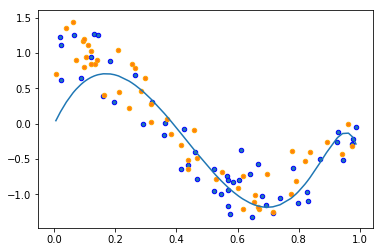

In [8]:
plt.scatter(X_train, y_train, edgecolor='b', s=20, label="Samples");
plt.scatter(X_test, y_test, edgecolor='orange', s=20, label="Samples");
plt.plot(X, model.predict(X.reshape(100, 1)[:,[0,0,0,0]] ** degrees));

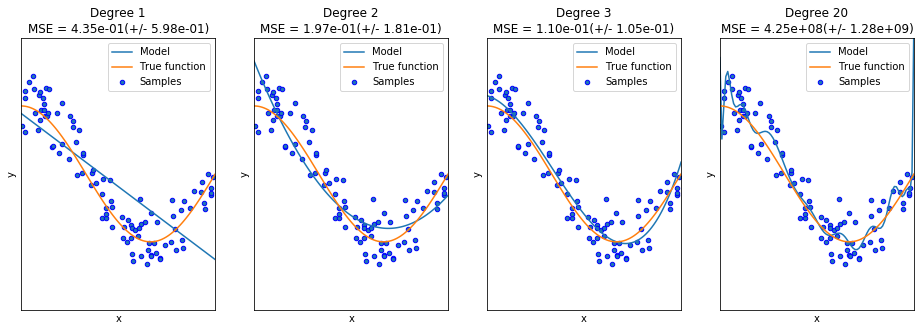

In [9]:

plt.figure(figsize=(16, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    
    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()